<a href="https://colab.research.google.com/github/indhu-parimi/Netflix-Sentiment-Analysis/blob/main/netflix_sentiment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Importing Libraries and Load Data**



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
!pip install vaderSentiment # This line installs vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # This imports SentimentIntensityAnalyzer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


In [2]:
netflix = pd.read_csv("/content/netflix_titles.csv.zip")


# Exploratory Data Analysis

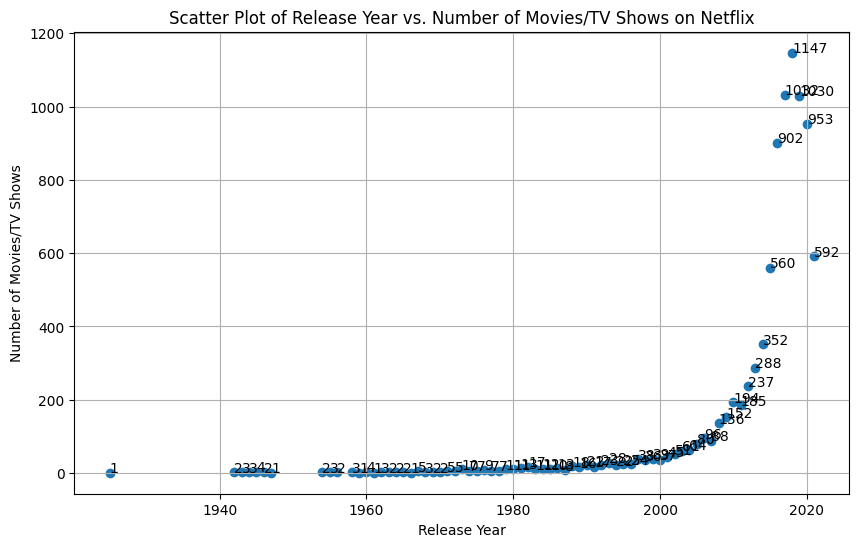

In [3]:
# plotting release_year vs. the count of movies/TV shows
release_year_counts = netflix.groupby('release_year').size()

plt.figure(figsize=(10, 6))
plt.scatter(release_year_counts.index, release_year_counts.values)
plt.xlabel('Release Year')
plt.ylabel('Number of Movies/TV Shows')
plt.title('Scatter Plot of Release Year vs. Number of Movies/TV Shows on Netflix')
plt.grid(True)

# Adding values as text to each point
for i, txt in enumerate(release_year_counts.values):
    plt.annotate(txt, (release_year_counts.index[i], release_year_counts.values[i]))

plt.show()

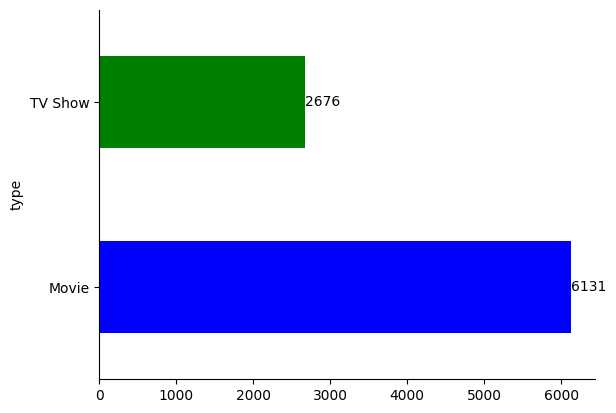

In [4]:
# Creating the horizontal bar plot
ax = netflix.groupby('type').size().plot(kind='barh', color=['blue', 'green'])

# Removing top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Adding the bar values
for p in ax.patches:
    width = p.get_width()  # Get the width of the bar
    ax.text(width + 0.1,       # X position of text (a bit to the right of the bar)
            p.get_y() + p.get_height() / 2, # Y position of text (center of the bar)
            '{:1.0f}'.format(width), # Text to display (formatted as integer)
            ha="left", va="center")  # Text alignment

Word Cloud of various rating movies

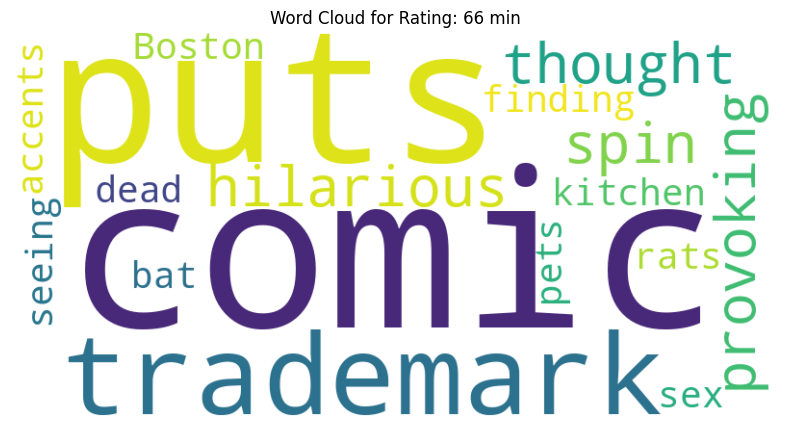

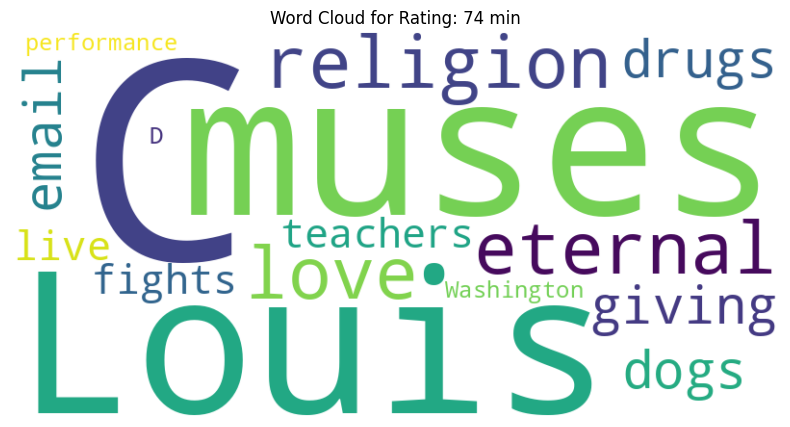

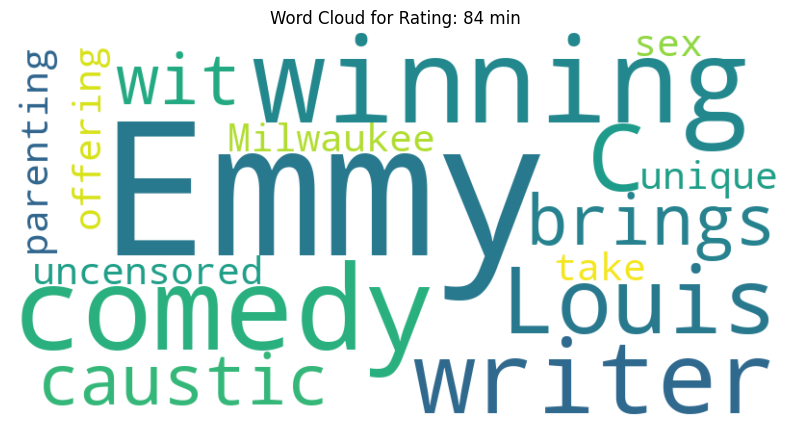

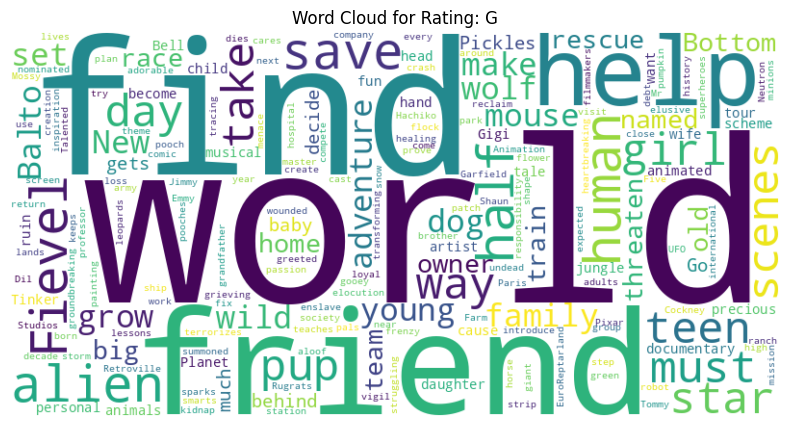

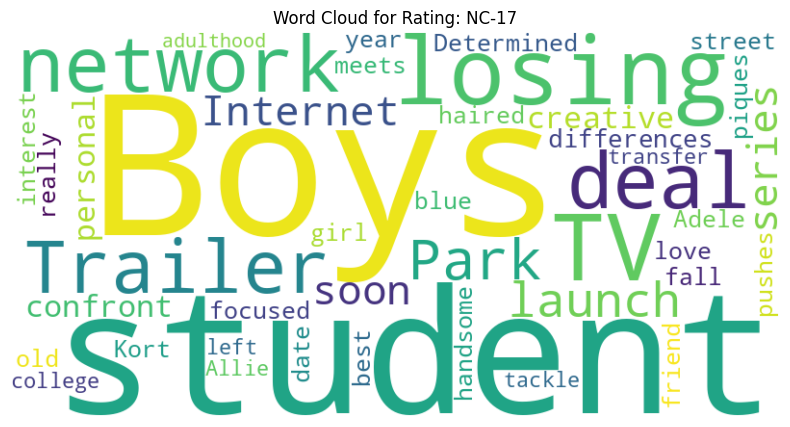

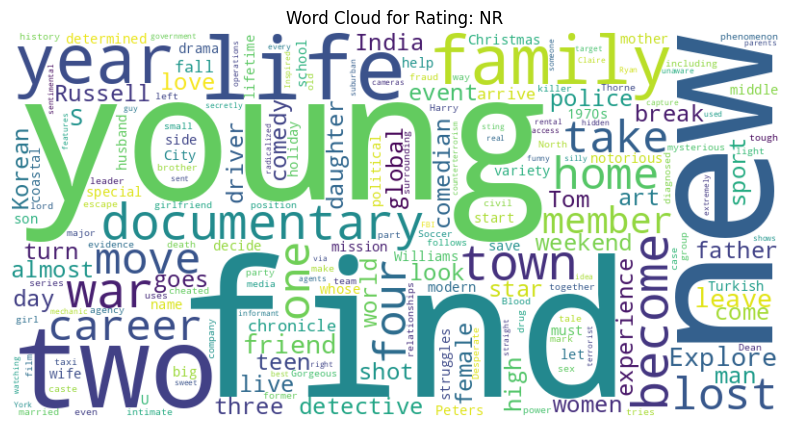

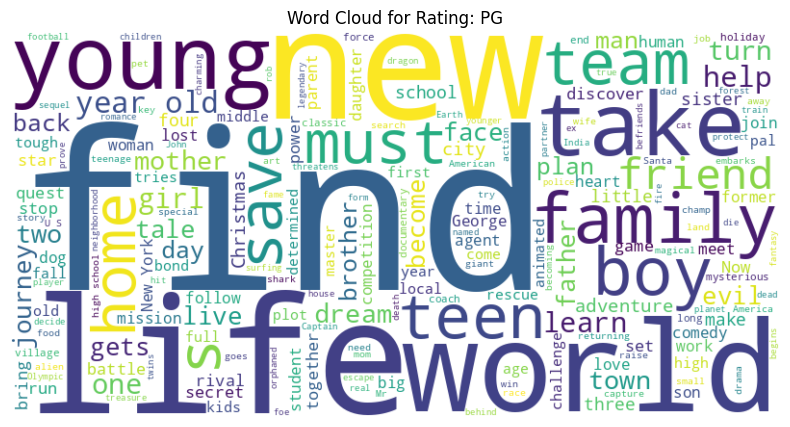

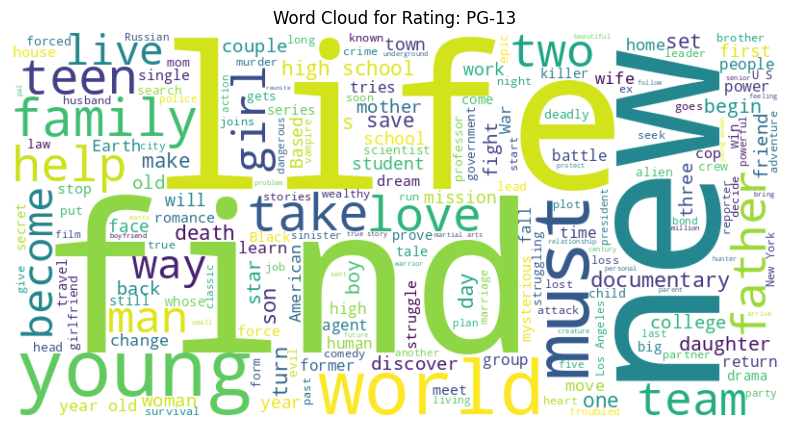

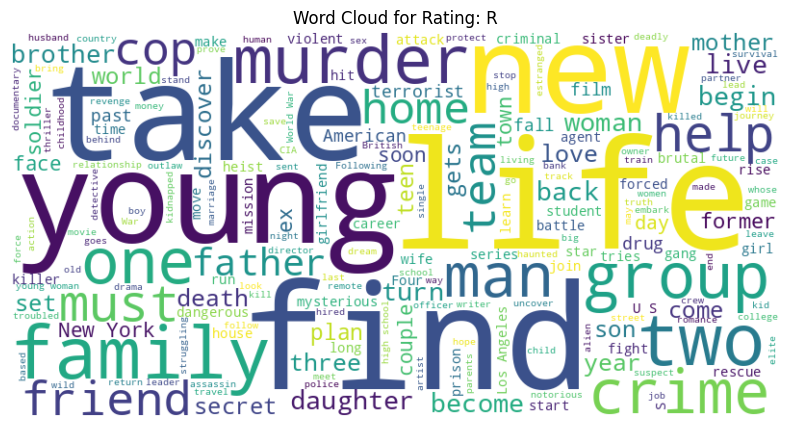

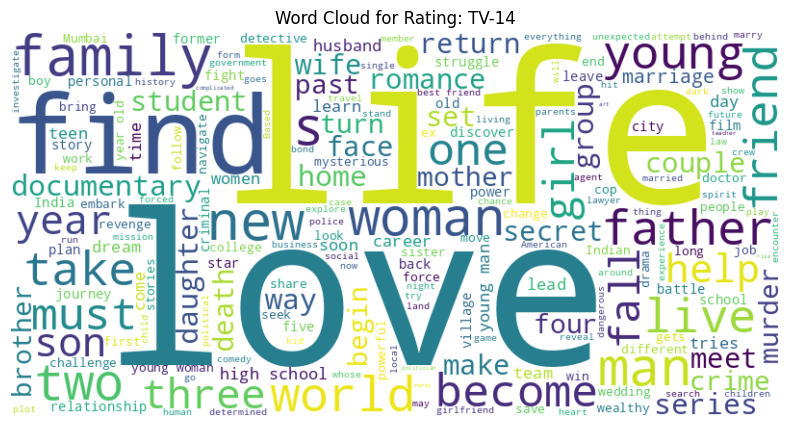

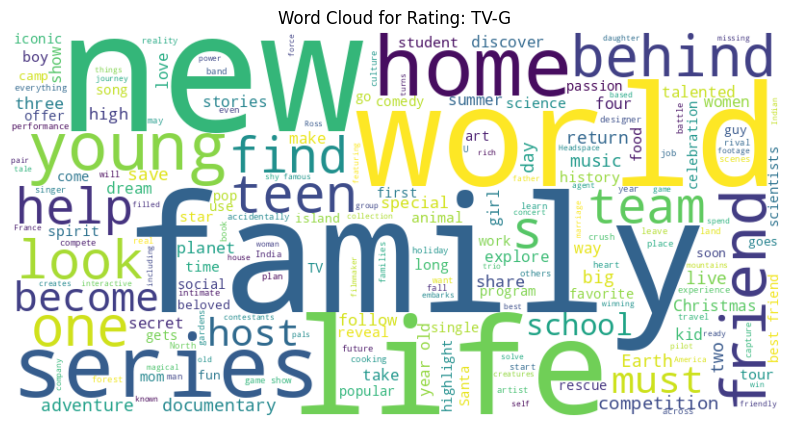

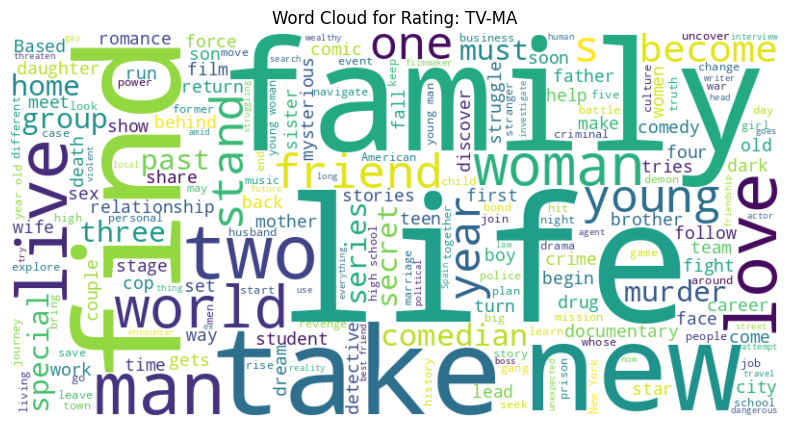

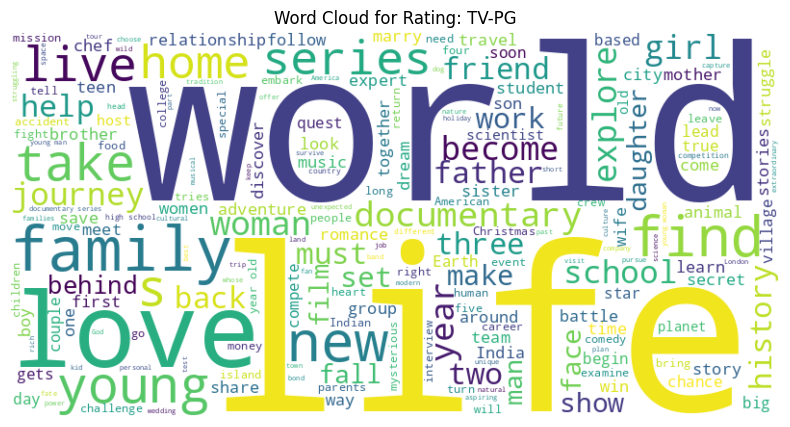

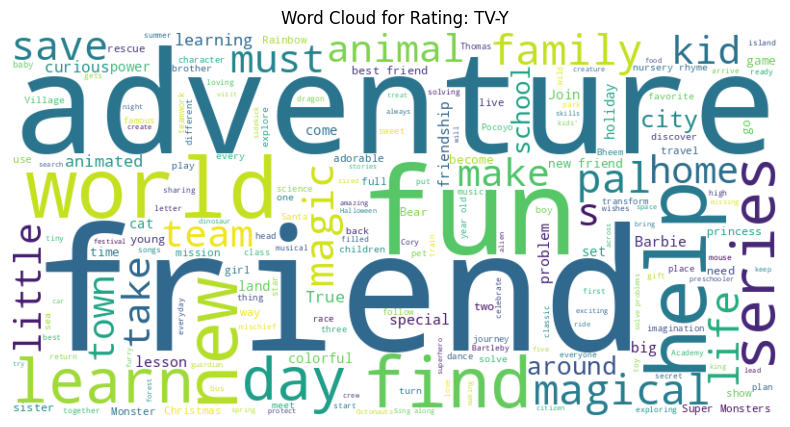

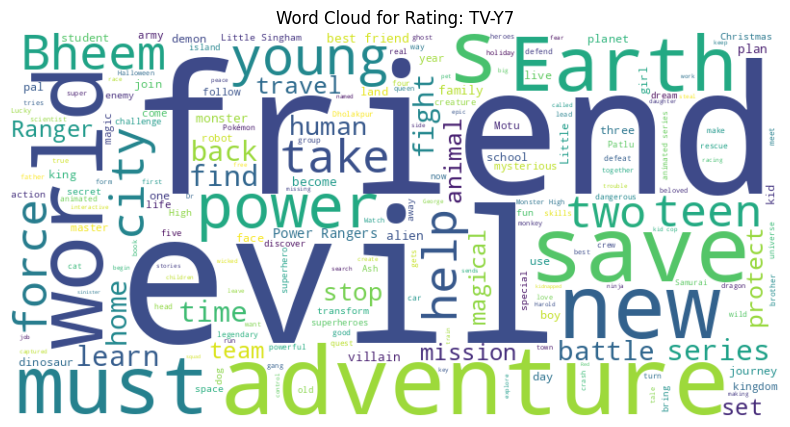

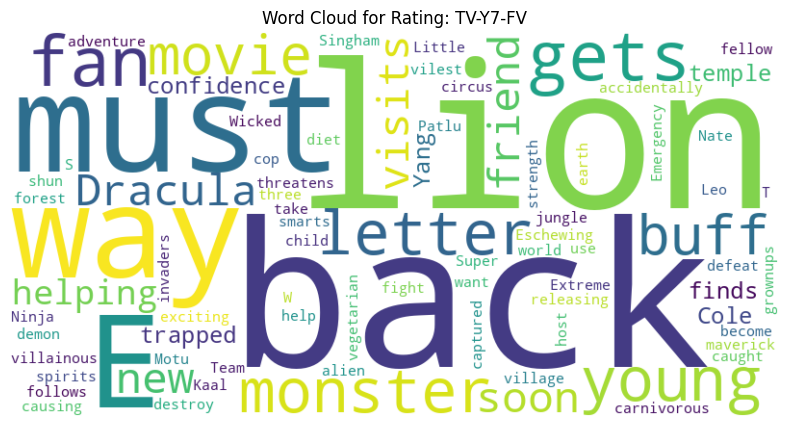

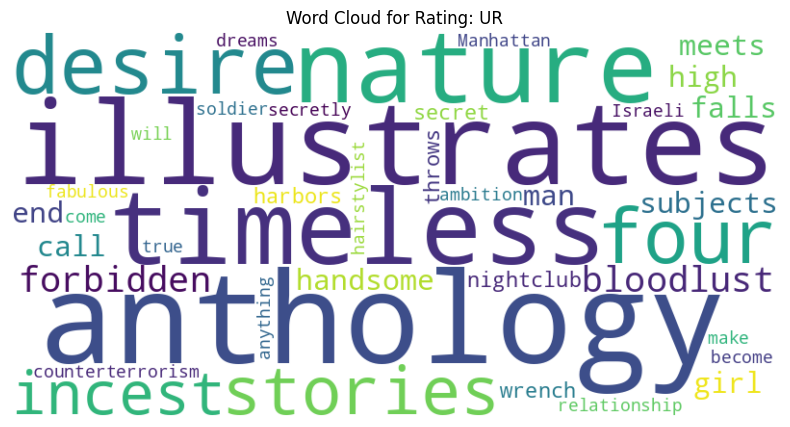

In [5]:
# Grouping the data by rating and concatenate descriptions for each group
rating_descriptions = netflix.groupby('rating')['description'].apply(lambda x: ' '.join(x)).reset_index()

# Creating a word cloud for each rating
for index, row in rating_descriptions.iterrows():
  rating = row['rating']
  descriptions = row['description']

  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(descriptions)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(f'Word Cloud for Rating: {rating}')
  plt.axis('off')
  plt.show()

# Data Preprocessing

In [6]:
# Checking for null values
print(netflix.isnull().sum())

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [7]:
netflix.shape

(8807, 12)

In [8]:
# Dropping rows with any null values in the specified columns
netflix.dropna(subset=['director', 'cast', 'country', 'date_added', 'rating', 'duration'], inplace=True)

# Resetting index after dropping rows
netflix.reset_index(drop=True, inplace=True)

# Verifying that null values have been removed
print(netflix.isnull().sum())

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


In [9]:
# Checking the data types of the columns
print(netflix.dtypes)

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


In [10]:
# Correcting the data types
netflix['show_id'] = netflix['show_id'].astype(str)  # Should be string
netflix['type'] = netflix['type'].astype(str)  # Should be string
netflix['title'] = netflix['title'].astype(str)  # Should be string
netflix['director'] = netflix['director'].astype(str)  # Should be string
netflix['cast'] = netflix['cast'].astype(str)  # Should be string
netflix['country'] = netflix['country'].astype(str)  # Should be string
netflix['date_added'] = pd.to_datetime(netflix['date_added'], errors='coerce')  # Should be datetime
netflix['release_year'] = netflix['release_year'].astype(int)  # Should be integer
netflix['rating'] = netflix['rating'].astype(str)  # Should be string
netflix['duration'] = netflix['duration'].astype(str)  # Should be string
netflix['listed_in'] = netflix['listed_in'].astype(str)  # Should be string
netflix['description'] = netflix['description'].astype(str)  # Should be string

# Verifying the corrected data types
print(netflix.dtypes)

show_id                 object
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
dtype: object


**Sentiment Analysis Using VADER**

In [11]:
# Initializing VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  # Return the compound score

# Applying the function to the description column
netflix['sentiment_score'] = netflix['description'].apply(get_sentiment)

# Categorizing sentiment
netflix['sentiment_category'] = np.where(netflix['sentiment_score'] >= 0.05, 'Positive',
                                              np.where(netflix['sentiment_score'] <= -0.05, 'Negative', 'Neutral'))

# Displaying the sentiment categories
print(netflix[['description', 'sentiment_score', 'sentiment_category']].head())

                                         description  sentiment_score  \
0  On a photo shoot in Ghana, an American model s...          -0.7845   
1  A talented batch of amateur bakers face off in...           0.9382   
2  A woman adjusting to life after a loss contend...          -0.6249   
3  After most of her family is murdered in a terr...          -0.9419   
4  When the father of the man she loves insists t...           0.8176   

  sentiment_category  
0           Negative  
1           Positive  
2           Negative  
3           Negative  
4           Positive  


**Data Visualization**

<ipython-input-12-958cfd35ac42>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=netflix, x='sentiment_category', palette='Set2')


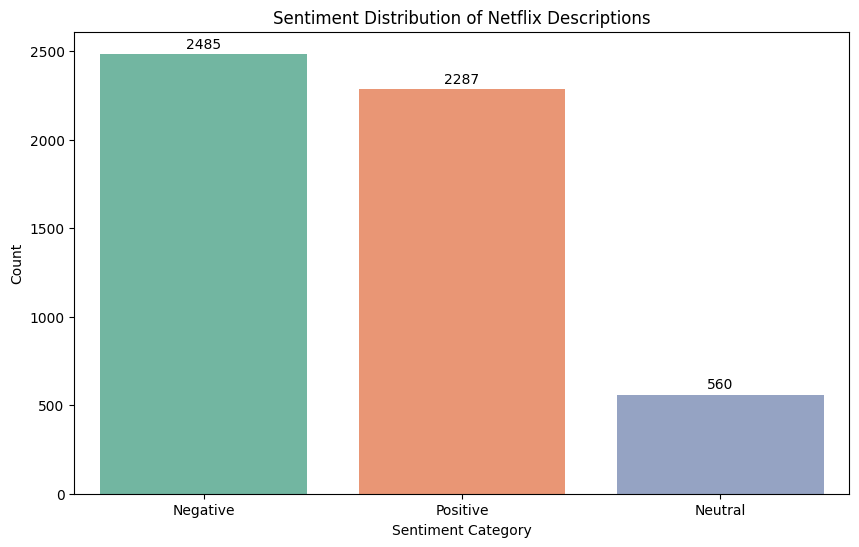

In [12]:
# Visualizing the sentiment distribution with count annotations
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=netflix, x='sentiment_category', palette='Set2')
plt.title('Sentiment Distribution of Netflix Descriptions')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

# Adding count annotations to the bars with vertical offset
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2)  # Add padding for vertical offset

plt.show()

# Preparing Data for Machine Learning

In [13]:
# Dropping rows with any null values in the specified columns
netflix.dropna(subset=['description', 'rating', 'type'], inplace=True)

# Initializing TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fitting and transforming the description column
tfidf_matrix = tfidf_vectorizer.fit_transform(netflix['description'])

# Converting the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Combining the TF-IDF DataFrame with other features
X = pd.concat([netflix[['type', 'rating']], tfidf_df], axis=1)

# Converting categorical variables into dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Targeting variable
y = netflix['sentiment_category']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Displaying the shape of the datasets
print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")


Training data shape: (4265, 14312), Testing data shape: (1067, 14312)


In [14]:
# Converting the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [15]:
# Saving the feature names
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')

['feature_names.pkl']

**Model Training and Evaluation**

Random Forest Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.81      0.75       523
     Neutral       1.00      0.01      0.02       111
    Positive       0.68      0.72      0.70       433

    accuracy                           0.69      1067
   macro avg       0.79      0.51      0.49      1067
weighted avg       0.72      0.69      0.65      1067



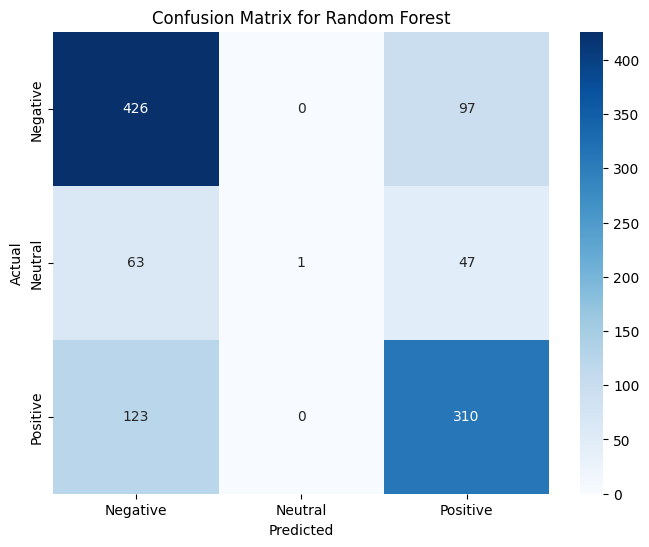

In [16]:
# Training Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Making predictions
rf_predictions = rf_model.predict(X_test)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Model Training with SVM**

SVM Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.82      0.78       523
     Neutral       0.50      0.02      0.03       111
    Positive       0.70      0.78      0.74       433

    accuracy                           0.72      1067
   macro avg       0.65      0.54      0.52      1067
weighted avg       0.70      0.72      0.69      1067



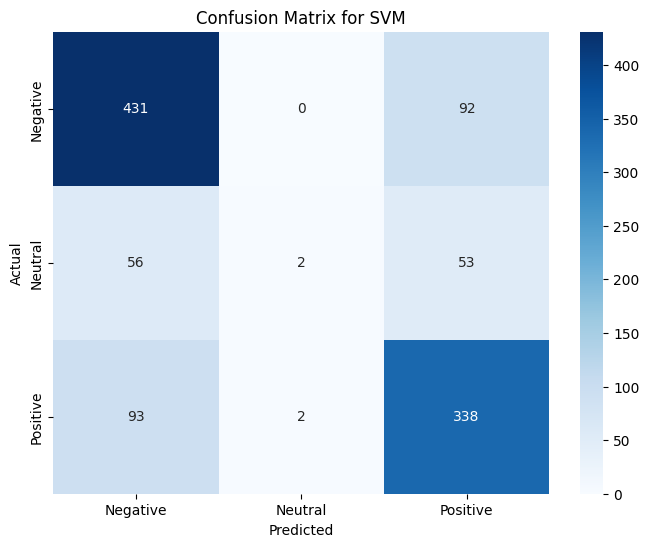

In [17]:
# Training SVM Classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Making predictions
svm_predictions = svm_model.predict(X_test)

# Evaluation
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

# Confusion Matrix
conf_matrix_svm = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model

In [18]:
# Saving the Random Forest model to a file
joblib.dump(rf_model, 'random_forest_model.pkl')

print("Random Forest model saved successfully!")

Random Forest model saved successfully!


# USER Testing

In [19]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# Loading the trained Random Forest model
rf_model = joblib.load('/content/random_forest_model.pkl')

# Loading the TF-IDF Vectorizer used for training
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')  # Ensure you save the vectorizer during training

# Loading the feature names
feature_names = joblib.load('feature_names.pkl')  # Ensure you load feature names

def predict_sentiment(user_type, user_rating, user_description):
    # Creating a DataFrame for the input
    input_data = pd.DataFrame({
        'type': [user_type],
        'rating': [user_rating],  # User-defined rating
        'description': [user_description]
    })

    # Transforming the description using the loaded TF-IDF vectorizer
    tfidf_matrix = tfidf_vectorizer.transform(input_data['description'])

    # Converting the TF-IDF matrix to a DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

    # Combining the TF-IDF DataFrame with other features
    combined_input = pd.concat([input_data[['type', 'rating']], tfidf_df], axis=1)

    # Converting categorical variables into dummy/indicator variables
    combined_input = pd.get_dummies(combined_input, drop_first=True)

    for col in feature_names:
        if col not in combined_input.columns:
            combined_input[col] = 0  # Add missing features with value 0

    # Reordering columns to match the training data
    combined_input = combined_input[feature_names]

    # Predicting sentiment category
    prediction = rf_model.predict(combined_input)

    return prediction[0]

# User testing interface
if __name__ == "__main__":
    user_type = input("Enter the type (Movie/TV Show): ")
    user_rating = input("Enter the rating (e.g., PG, PG-13, R, etc.): ")  # User-defined rating
    user_description = input("Enter the description: ")

    predicted_sentiment = predict_sentiment(user_type, user_rating, user_description)
    print(f"The predicted sentiment is: {predicted_sentiment}")

Enter the type (Movie/TV Show): movie
Enter the rating (e.g., PG, PG-13, R, etc.): PG-13
Enter the description: As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.
The predicted sentiment is: Negative
